# Credit card fraud detection with machine learning

## 1.0 Problem and purpose

Uncaught fraudulent credit card transactions have lasting negative impact on the credit card company, the client, and parties involved in the transaction such as vendors and service-providers. Naturally, there are socio-economic repercussions such as distrust in the system and deterred progress. In this domain, we see issues of skewed data, stationarity, and scarcity. This makes detecting fraudulent credit card transations an interesting problem.

The purpose of this case study is to help detect fraudulent credit card transactions with supervised machine learning. We tackle unbalanced data and focus on false positives and false negatives in a static learning setting (as opposed to incremental learning). 

## 2.0 Dataset(s)

The dataset contains credit card transactions of Europe-based cardholders in September 2013 over a span of two days. The dataset is comprised of:
* 28 pre-PCA-transformed features to protect privacy
* a numerical feature called "Time" which represents the number of seconds elapsed between this transaction and the first transaction in the dataset.
* a numerical feature called "Amount" which shows the value of the transaction
* the binary label called "Class" which is either valued 1 for fraudulent or 0 for non-fraudulent transactions
* 284,807 examples

The data was sourced from: https://www.kaggle.com/mlg-ulb/creditcardfraud and is owned by the [Machine Learning Group of the Computer Science Department of Université Libre de Bruxelles](https://mlg.ulb.ac.be/wordpress/)

## 3.0 Challenge(s) and approach

Challenge

The dataset is highly unbalanced having 492 (0.172%) transactions labeled fraudulent out of the 284,807 examples. This could lead to overfitting and mistaken correlations. Additionally, it is going to be more costly to let fraudulent transactions get past the model as well as labeling someone's transaction as fraud when it isn't.

There are a number of techniques that we can use to address this such as focusing on the apporpriate metrics, oversampling the minority class, undersampling the majority class, upsampling with SMOTE, and modifying the algorithms. 

Approach

* We tackle the unbalanced data by undersampling the majority class. Sampling isn't highly specific in taking examples from one class but it is easy to implement and understand. 

* We are interested in a high Recall, TP/TP+FN and a high Precision, TP/TP+FP, and the two combined in F1, P*R/P+R. Because false negatives and false positives are going to be costly, these metrics are more meaningful compared to other metrics such as accuracy.
 
* We have a single learning batch to work with as opposed to jumping on a continuous stream because it makes things simpler and faster to start with.

* We will look at Random Forests (RF), Support Vector Machine (SVM), Gradient Boosting (GB), and Decision Tree (DT) classifier techniques because they are simple and speedy and work well in a static setting. A study that compared various techniques on fraud detection shows that RF tends outperform other techniques (Dal Pazzolo and Caeleen on 'Learned lessons in credit card fraud detection from a practitioner perspective').

## 4.0 Implementation

In [16]:
# Set-up libraries
import os
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Check source
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    

../input/creditcardfraud/creditcard.csv


In [3]:
# Load data
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
# Check for missing values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

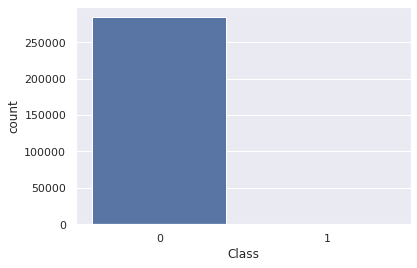

In [5]:
# Explore label breakdown
df['Class'].value_counts()
sns.countplot(df['Class'])

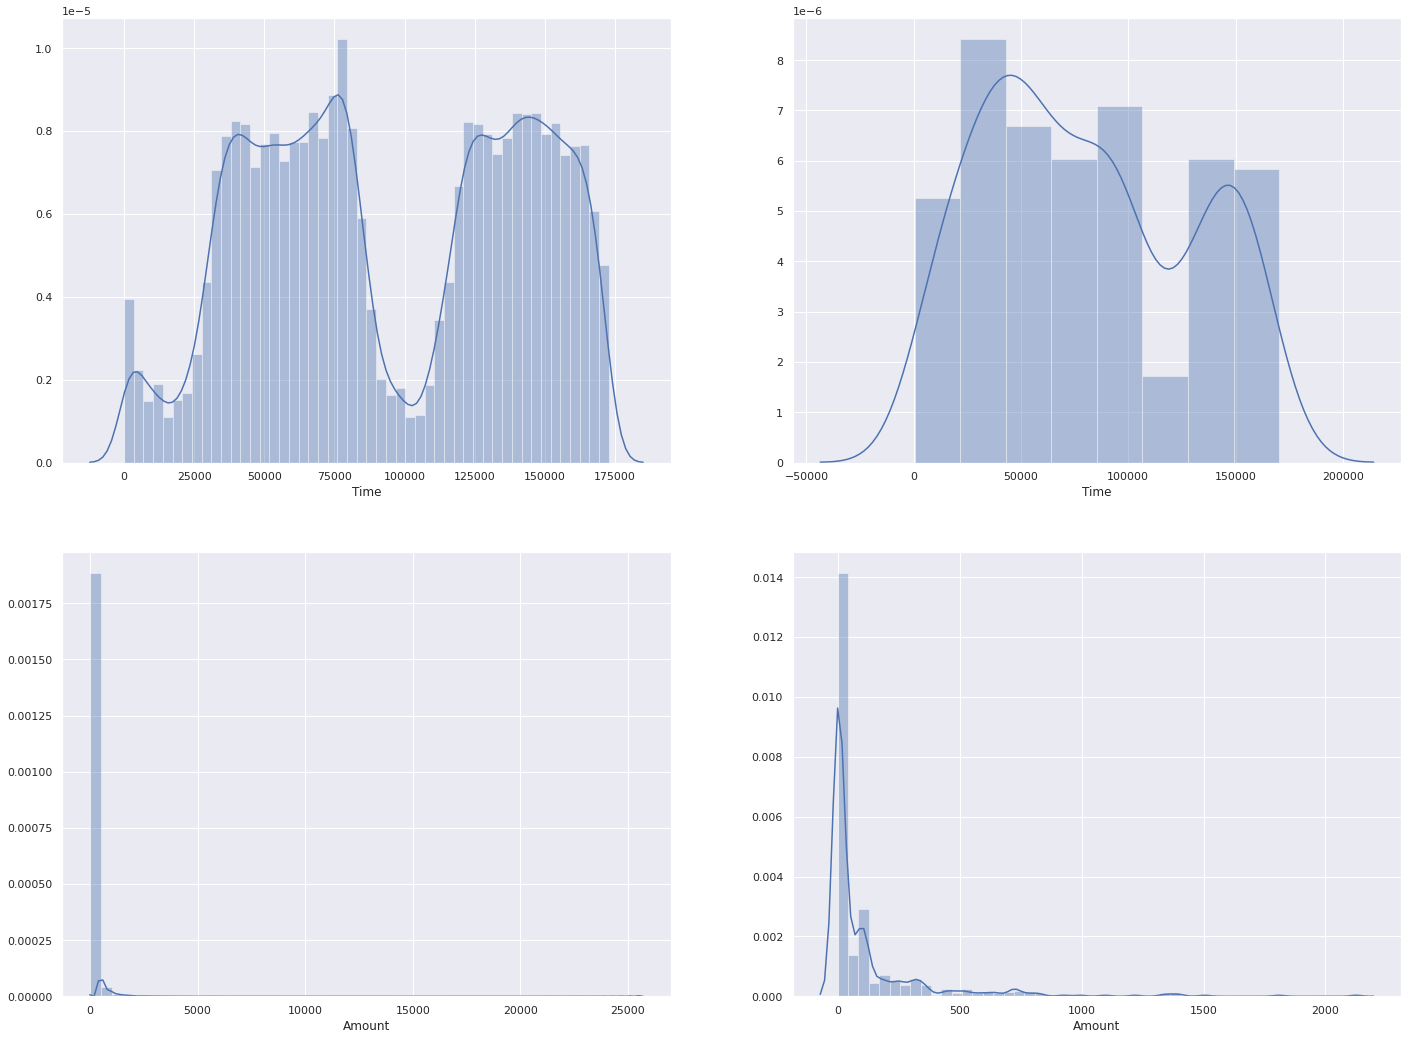

In [6]:
# Explore data visually
plt.figure(figsize=(24,18))

plt.subplot(221)
sns.distplot(df[df['Class']==0]['Time'])

plt.subplot(222)
sns.distplot(df[df['Class']==1]['Time'])

plt.subplot(223)
sns.distplot(df[df['Class']==0]['Amount'])

plt.subplot(224)
sns.distplot(df[df['Class']==1]['Amount'])


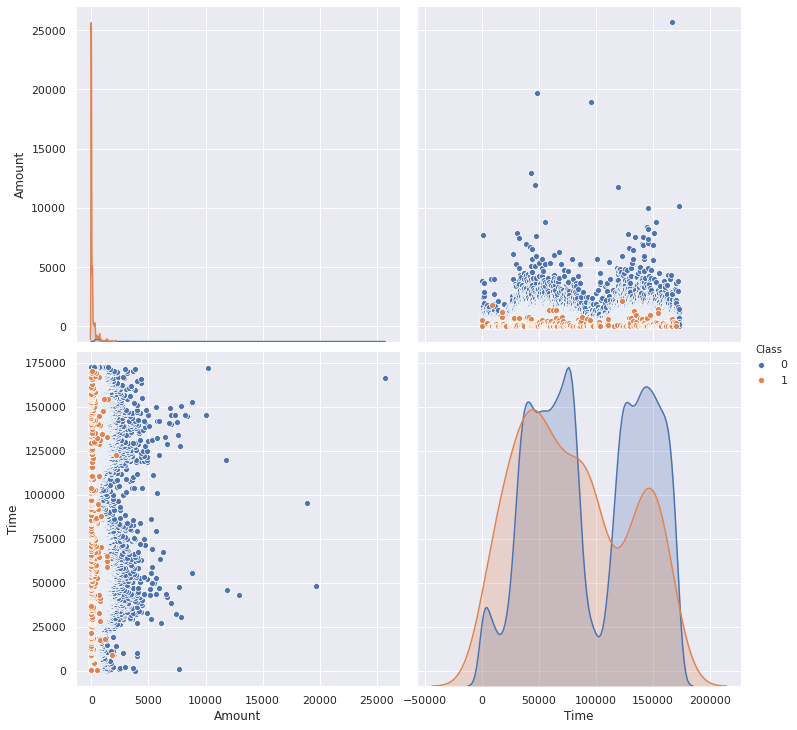

In [7]:
sns.pairplot(df[['Amount', 'Time', 'Class']], hue='Class', height=5)

In [8]:
# Summarise 
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
# Scale non-PCA-transformed features
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
print('Amount\n', df['Amount'].describe())
df['Time'] = StandardScaler().fit_transform(df[['Time']])
print('\nTime\n', df['Time'].describe())

Amount
 count    2.848070e+05
mean     3.202236e-16
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64

Time
 count    2.848070e+05
mean    -1.050379e-14
std      1.000002e+00
min     -1.996583e+00
25%     -8.552120e-01
50%     -2.131453e-01
75%      9.372174e-01
max      1.642058e+00
Name: Time, dtype: float64


All fraud examples shape:  (492, 31)
Random legit examples shape:  (492, 31)
       Time        V1        V2        V3        V4        V5        V6  \
0 -0.557127  1.232604 -0.548931  1.087873  0.894082 -1.433055 -0.356797   
1  0.927268 -0.895521  0.279457  1.063142 -1.694069 -0.481510 -1.098127   
2 -1.762187 -1.426623  4.141986 -9.804103  6.666273 -4.749527 -2.073129   
3 -0.910121 -0.431589 -0.477900  1.572834 -2.537477 -0.681907 -0.569438   
4  1.221215 -0.364750  1.116682  0.237419 -0.716105  0.498563 -1.096677   

          V7        V8        V9  ...       V21       V22       V23       V24  \
0  -0.717492  0.003167 -0.100397  ... -0.448671 -0.517568  0.012833  0.699217   
1  -0.042581  0.416070  0.505971  ... -0.026481 -0.360074  0.096732  0.038799   
2 -10.089931  2.791345 -3.249516  ...  1.865679  0.407809  0.605809 -0.769348   
3  -0.308009  0.042734 -2.577180  ... -0.089838 -0.062440 -0.149151 -0.037858   
4   1.300272 -0.463788  0.357802  ... -0.368944 -0.515464  0.088286

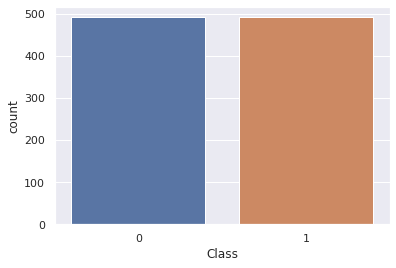

In [10]:
# Undersample majority class
sub_df_fraud = df.loc[df['Class']==1]
print('All fraud examples shape: ', sub_df_fraud.shape)

sub_df_legit_all = df.loc[df['Class']==0]
sub_df_legit = sub_df_legit_all.sample(sub_df_fraud.shape[0], random_state=0)
print('Random legit examples shape: ', sub_df_legit.shape)

df_undersampled = pd.concat([sub_df_fraud, sub_df_legit])
df_undersampled = df_undersampled.sample(frac=1, random_state=0).reset_index(drop=True) #shuffle
print(df_undersampled.head())

df_undersampled['Class'].value_counts()
sns.countplot(df_undersampled['Class'])

In [11]:
# Split data into 80% train and 20% validation
X = df_undersampled.drop('Class', axis=1)
y = df_undersampled['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(787, 30) (787,) (197, 30) (197,)


In [31]:
# Build and train models
models = [SVC(kernel='rbf', random_state=0), 
          SVC(kernel='linear', random_state=0), 
          xgb.XGBClassifier(), 
          DecisionTreeClassifier(),
          RandomForestClassifier()]

model_names = ['SVM Non-Linear', 
               'SVM Linear', 
               'Gradient Boosting', 
               'Decision Tree Classifier',
               'Random Forest Classifer']

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    print(
          confusion_matrix(y_val, model.predict(X_val)),
          '\n',
          model_names[i]
          + '--- \n' +
          classification_report(y_val, model.predict(X_val))          
          
         )

[[101   0]
 [ 12  84]] 
 SVM Non-Linear--- 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       101
           1       1.00      0.88      0.93        96

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197

[[100   1]
 [ 11  85]] 
 SVM Linear--- 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       101
           1       0.99      0.89      0.93        96

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

[[99  2]
 [ 7 89]] 
 Gradient Boosting--- 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       101
           1       0.98      0.93      0.95        96

    accuracy                           0.95       197
 

## 5.0 Results discussion

Best Recall

The models that yielded the best Recall are GB, DT, RF.
Here, we can answer the question, out of all the actual positive examples, how much (percentage) did the model correctly identify? 
In other words, out of all the actual fraudulent transactions, how many were we able to correctly identify as fraud?
Out of all the fraudulent transactions, the models correctly told us that a transaction is fraud 93%, 93%, and 89% of the time, respectively.

Best Precision

The models that yielded the best Precision are SVM (Linear), GB, RF.
Here, we can answer the question, out of all examples that the model identified as positive, how much (percentage) are actually correct? 
In other words, out of all the examples classified as fraudulent, how many are actually fraudulent?
We can think of this as the accuracy of the model per class, which is the fraudulent class here.
Out of all the transactions tht the models said are fraudulent, 99%, 98%, and 99% are actually correct.

Best F1

The models that yielded the best F1-score are GB and RF.
This is the combined effect of Recall and Precision and gives us a sense of the model's performance in identifying false negatives and false positives.
The ability of our models to identify frauduelent and non-fraudulent activities correctly are about 95% and 93%, respectively. 

Ways to improve

We consistently see GB and RF performing well given the metrics that we are most interested in.
What we can do to further improve our best models' metrics is to penalise false negatives and false positives.
We can also prioritise one metric over the other. For instance, we could decide that it's costlier to classify a fraudulent transaction as legitimate than to classify a legitimate transaction as fraud.
Meanwhile, we can also try more other balancing techniques on our data such as SMOTE and EasyEnsemble. 
Moreover, these results are based on 984 examples. Increasing the number of examples may further improve our metrics.


## 6.0 Conclusion

Case-study summary 

In this case study, we used a number of widely used supervised classification techniques to detect fraudulent transactions in an unbalanced dataset. In addition to these techniques matching the requirements of the problem, they are simple and speedy, and they work well in a static setting where the data is non-streaming. We also used undersampling, which although it does not take consideration specifics information in the dataset when we downsized, it is easy to implement and understand. It provided us with a good enough dataset to work with. Lastly, we were more interested in the false negatives and false positives so we focused on the Recall, Precision, and F1 scores. Archetypal machine learning measures such as Accuracy may not be as meaningful here.


Future directions

It would be interesting to work on a similar problem in a non-static setting where the data streams and has skewed distribution. Fraudulent initiatives change over time. The dilema is, when and how should a model remember and forget what it has learned about fraudulent transactions? At what rate should it forget? 

It would also be interesting to rank the results. Humans in the loop who end up reviewing the results of the model are limited in capacity. If the model can rank the most useful findings for them to investigate further, the process would be more efficient and effective.



Real-world retrospective

In business settings, it is crucial to explain to the business what trade-offs are being made and why, in a language that they can relate to. It is also important to explain the possible short-term and long-term implications of these choices to the business. This helps them make the best use of the model we built for them and helps us develop impactful models.

## 7.0 References
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019